In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2023-09-18 14:59:17.362303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 14:59:20.691852: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-18 14:59:20.692027: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

2.11.0


In [2]:
# !git clone https://github.com/EricMartinezIllamola/asl-global.git

In [3]:
# !pip install split-folders 

In [4]:
# import splitfolders
# import os

In [5]:
# path = "asl-global/asl-global"

# splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.7, 0.15, 0.15))

In [6]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [7]:
tf.config.experimental.list_physical_devices()

2023-09-18 14:59:24.846654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-18 14:59:24.860960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-18 14:59:24.863735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 32 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 4966 images belonging to 34 classes.
Found 1048 images belonging to 34 classes.
Found 1088 images belonging to 34 classes.


In [10]:
#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-18 14:59:25.762164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 14:59:25.763500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-18 14:59:25.765560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-18 14:59:25.767286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
##DEFINIMOS EL MODELO
num_classes = 34
epochs = 200

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dense(4096, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation = 'softmax'))

22


In [12]:
## EJECUCION DEL MODELO
# with tf.device("/CPU:0"):
# with tf.device("/GPU:0"):
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model-03', verbose=1, save_best_only=True,
                               monitor = "accuracy", mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.000001)

history= model.fit(train_generator, callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/200


2023-09-18 14:59:31.649791: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-09-18 14:59:33.801884: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f665e044550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-18 14:59:33.801942: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-09-18 14:59:33.885736: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


156/156 [==============================] - ETA: 0s - loss: 12.6129 - accuracy: 0.0284
Epoch 1: accuracy improved from -inf to 0.02839, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 21s 94ms/step - loss: 12.6129 - accuracy: 0.0284 - lr: 0.0010
Epoch 2/200
156/156 [==============================] - ETA: 0s - loss: 12.4369 - accuracy: 0.0683
Epoch 2: accuracy improved from 0.02839 to 0.06826, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 97ms/step - loss: 12.4369 - accuracy: 0.0683 - lr: 0.0010
Epoch 3/200
156/156 [==============================] - ETA: 0s - loss: 12.0610 - accuracy: 0.1089
Epoch 3: accuracy improved from 0.06826 to 0.10894, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 96ms/step - loss: 12.0610 - accuracy: 0.1089 - lr: 0.0010
Epoch 4/200
156/156 [==============================] - ETA: 0s - loss: 11.6243 - accuracy: 0.1959
Epoch 4: accuracy improved from 0.10894 to 0.19593, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 97ms/step - loss: 11.6243 - accuracy: 0.1959 - lr: 0.0010
Epoch 5/200
156/156 [==============================] - ETA: 0s - loss: 11.2281 - accuracy: 0.2777
Epoch 5: accuracy improved from 0.19593 to 0.27769, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 95ms/step - loss: 11.2281 - accuracy: 0.2777 - lr: 0.0010
Epoch 6/200
156/156 [==============================] - ETA: 0s - loss: 10.8634 - accuracy: 0.3594
Epoch 6: accuracy improved from 0.27769 to 0.35944, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 98ms/step - loss: 10.8634 - accuracy: 0.3594 - lr: 0.0010
Epoch 7/200
156/156 [==============================] - ETA: 0s - loss: 10.5181 - accuracy: 0.4525
Epoch 7: accuracy improved from 0.35944 to 0.45248, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 96ms/step - loss: 10.5181 - accuracy: 0.4525 - lr: 0.0010
Epoch 8/200
156/156 [==============================] - ETA: 0s - loss: 10.2323 - accuracy: 0.5167
Epoch 8: accuracy improved from 0.45248 to 0.51671, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 98ms/step - loss: 10.2323 - accuracy: 0.5167 - lr: 0.0010
Epoch 9/200
156/156 [==============================] - ETA: 0s - loss: 9.9678 - accuracy: 0.5805
Epoch 9: accuracy improved from 0.51671 to 0.58055, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 95ms/step - loss: 9.9678 - accuracy: 0.5805 - lr: 0.0010
Epoch 10/200
156/156 [==============================] - ETA: 0s - loss: 9.7441 - accuracy: 0.6377
Epoch 10: accuracy improved from 0.58055 to 0.63774, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 98ms/step - loss: 9.7441 - accuracy: 0.6377 - lr: 0.0010
Epoch 11/200
156/156 [==============================] - ETA: 0s - loss: 9.5708 - accuracy: 0.6698
Epoch 11: accuracy improved from 0.63774 to 0.66975, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 98ms/step - loss: 9.5708 - accuracy: 0.6698 - lr: 0.0010
Epoch 12/200
156/156 [==============================] - ETA: 0s - loss: 9.4097 - accuracy: 0.7052
Epoch 12: accuracy improved from 0.66975 to 0.70520, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 95ms/step - loss: 9.4097 - accuracy: 0.7052 - lr: 0.0010
Epoch 13/200
156/156 [==============================] - ETA: 0s - loss: 9.2817 - accuracy: 0.7271
Epoch 13: accuracy improved from 0.70520 to 0.72714, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 97ms/step - loss: 9.2817 - accuracy: 0.7271 - lr: 0.0010
Epoch 14/200
156/156 [==============================] - ETA: 0s - loss: 9.1543 - accuracy: 0.7483
Epoch 14: accuracy improved from 0.72714 to 0.74829, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 95ms/step - loss: 9.1543 - accuracy: 0.7483 - lr: 0.0010
Epoch 15/200
156/156 [==============================] - ETA: 0s - loss: 9.0616 - accuracy: 0.7624
Epoch 15: accuracy improved from 0.74829 to 0.76238, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 98ms/step - loss: 9.0616 - accuracy: 0.7624 - lr: 0.0010
Epoch 16/200
156/156 [==============================] - ETA: 0s - loss: 8.9534 - accuracy: 0.7823
Epoch 16: accuracy improved from 0.76238 to 0.78232, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 95ms/step - loss: 8.9534 - accuracy: 0.7823 - lr: 0.0010
Epoch 17/200
156/156 [==============================] - ETA: 0s - loss: 8.8494 - accuracy: 0.8063
Epoch 17: accuracy improved from 0.78232 to 0.80628, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 96ms/step - loss: 8.8494 - accuracy: 0.8063 - lr: 0.0010
Epoch 18/200
156/156 [==============================] - ETA: 0s - loss: 8.7654 - accuracy: 0.8097
Epoch 18: accuracy improved from 0.80628 to 0.80971, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 95ms/step - loss: 8.7654 - accuracy: 0.8097 - lr: 0.0010
Epoch 19/200
156/156 [==============================] - ETA: 0s - loss: 8.6832 - accuracy: 0.8186
Epoch 19: accuracy improved from 0.80971 to 0.81857, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 98ms/step - loss: 8.6832 - accuracy: 0.8186 - lr: 0.0010
Epoch 20/200
156/156 [==============================] - ETA: 0s - loss: 8.6070 - accuracy: 0.8276
Epoch 20: accuracy improved from 0.81857 to 0.82763, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 96ms/step - loss: 8.6070 - accuracy: 0.8276 - lr: 0.0010
Epoch 21/200
156/156 [==============================] - ETA: 0s - loss: 8.5258 - accuracy: 0.8421
Epoch 21: accuracy improved from 0.82763 to 0.84213, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 96ms/step - loss: 8.5258 - accuracy: 0.8421 - lr: 0.0010
Epoch 22/200
156/156 [==============================] - ETA: 0s - loss: 8.4756 - accuracy: 0.8441
Epoch 22: accuracy improved from 0.84213 to 0.84414, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 97ms/step - loss: 8.4756 - accuracy: 0.8441 - lr: 0.0010
Epoch 23/200
156/156 [==============================] - ETA: 0s - loss: 8.3944 - accuracy: 0.8468
Epoch 23: accuracy improved from 0.84414 to 0.84676, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 96ms/step - loss: 8.3944 - accuracy: 0.8468 - lr: 0.0010
Epoch 24/200
156/156 [==============================] - ETA: 0s - loss: 8.3307 - accuracy: 0.8526
Epoch 24: accuracy improved from 0.84676 to 0.85260, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 97ms/step - loss: 8.3307 - accuracy: 0.8526 - lr: 0.0010
Epoch 25/200
156/156 [==============================] - ETA: 0s - loss: 8.2371 - accuracy: 0.8647
Epoch 25: accuracy improved from 0.85260 to 0.86468, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 95ms/step - loss: 8.2371 - accuracy: 0.8647 - lr: 0.0010
Epoch 26/200
156/156 [==============================] - ETA: 0s - loss: 8.2041 - accuracy: 0.8598
Epoch 26: accuracy did not improve from 0.86468
156/156 [==============================] - 10s 62ms/step - loss: 8.2041 - accuracy: 0.8598 - lr: 0.0010
Epoch 27/200
156/156 [==============================] - ETA: 0s - loss: 8.1354 - accuracy: 0.8689
Epoch 27: accuracy improved from 0.86468 to 0.86891, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 98ms/step - loss: 8.1354 - accuracy: 0.8689 - lr: 0.0010
Epoch 28/200
156/156 [==============================] - ETA: 0s - loss: 8.0662 - accuracy: 0.8786
Epoch 28: accuracy improved from 0.86891 to 0.87857, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 96ms/step - loss: 8.0662 - accuracy: 0.8786 - lr: 0.0010
Epoch 29/200
156/156 [==============================] - ETA: 0s - loss: 7.9958 - accuracy: 0.8808
Epoch 29: accuracy improved from 0.87857 to 0.88079, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 97ms/step - loss: 7.9958 - accuracy: 0.8808 - lr: 0.0010
Epoch 30/200
156/156 [==============================] - ETA: 0s - loss: 7.9295 - accuracy: 0.8894
Epoch 30: accuracy improved from 0.88079 to 0.88945, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 96ms/step - loss: 7.9295 - accuracy: 0.8894 - lr: 0.0010
Epoch 31/200
156/156 [==============================] - ETA: 0s - loss: 7.8911 - accuracy: 0.8870
Epoch 31: accuracy did not improve from 0.88945
156/156 [==============================] - 10s 63ms/step - loss: 7.8911 - accuracy: 0.8870 - lr: 0.0010
Epoch 32/200
156/156 [==============================] - ETA: 0s - loss: 7.8312 - accuracy: 0.8907
Epoch 32: accuracy improved from 0.88945 to 0.89066, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 95ms/step - loss: 7.8312 - accuracy: 0.8907 - lr: 0.0010
Epoch 33/200
156/156 [==============================] - ETA: 0s - loss: 7.7773 - accuracy: 0.8951
Epoch 33: accuracy improved from 0.89066 to 0.89509, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 97ms/step - loss: 7.7773 - accuracy: 0.8951 - lr: 0.0010
Epoch 34/200
156/156 [==============================] - ETA: 0s - loss: 7.7107 - accuracy: 0.9023
Epoch 34: accuracy improved from 0.89509 to 0.90234, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 95ms/step - loss: 7.7107 - accuracy: 0.9023 - lr: 0.0010
Epoch 35/200
156/156 [==============================] - ETA: 0s - loss: 7.6691 - accuracy: 0.8947
Epoch 35: accuracy did not improve from 0.90234
156/156 [==============================] - 10s 63ms/step - loss: 7.6691 - accuracy: 0.8947 - lr: 0.0010
Epoch 36/200
156/156 [==============================] - ETA: 0s - loss: 7.6031 - accuracy: 0.9068
Epoch 36: accuracy improved from 0.90234 to 0.90677, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 97ms/step - loss: 7.6031 - accuracy: 0.9068 - lr: 0.0010
Epoch 37/200
156/156 [==============================] - ETA: 0s - loss: 7.5592 - accuracy: 0.9064
Epoch 37: accuracy did not improve from 0.90677
156/156 [==============================] - 10s 63ms/step - loss: 7.5592 - accuracy: 0.9064 - lr: 0.0010
Epoch 38/200
156/156 [==============================] - ETA: 0s - loss: 7.5046 - accuracy: 0.9090
Epoch 38: accuracy improved from 0.90677 to 0.90898, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 94ms/step - loss: 7.5046 - accuracy: 0.9090 - lr: 0.0010
Epoch 39/200
156/156 [==============================] - ETA: 0s - loss: 7.4606 - accuracy: 0.9080
Epoch 39: accuracy did not improve from 0.90898
156/156 [==============================] - 10s 63ms/step - loss: 7.4606 - accuracy: 0.9080 - lr: 0.0010
Epoch 40/200
156/156 [==============================] - ETA: 0s - loss: 7.4007 - accuracy: 0.9080
Epoch 40: accuracy did not improve from 0.90898
156/156 [==============================] - 10s 63ms/step - loss: 7.4007 - accuracy: 0.9080 - lr: 0.0010
Epoch 41/200
156/156 [==============================] - ETA: 0s - loss: 7.3453 - accuracy: 0.9174
Epoch 41: accuracy improved from 0.90898 to 0.91744, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 98ms/step - loss: 7.3453 - accuracy: 0.9174 - lr: 0.0010
Epoch 42/200
156/156 [==============================] - ETA: 0s - loss: 7.3050 - accuracy: 0.9150
Epoch 42: accuracy did not improve from 0.91744
156/156 [==============================] - 10s 66ms/step - loss: 7.3050 - accuracy: 0.9150 - lr: 0.0010
Epoch 43/200
156/156 [==============================] - ETA: 0s - loss: 7.2436 - accuracy: 0.9184
Epoch 43: accuracy improved from 0.91744 to 0.91845, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 96ms/step - loss: 7.2436 - accuracy: 0.9184 - lr: 0.0010
Epoch 44/200
156/156 [==============================] - ETA: 0s - loss: 7.1966 - accuracy: 0.9197
Epoch 44: accuracy improved from 0.91845 to 0.91965, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 98ms/step - loss: 7.1966 - accuracy: 0.9197 - lr: 0.0010
Epoch 45/200
156/156 [==============================] - ETA: 0s - loss: 7.1503 - accuracy: 0.9265
Epoch 45: accuracy improved from 0.91965 to 0.92650, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 97ms/step - loss: 7.1503 - accuracy: 0.9265 - lr: 0.0010
Epoch 46/200
156/156 [==============================] - ETA: 0s - loss: 7.0940 - accuracy: 0.9237
Epoch 46: accuracy did not improve from 0.92650
156/156 [==============================] - 10s 62ms/step - loss: 7.0940 - accuracy: 0.9237 - lr: 0.0010
Epoch 47/200
156/156 [==============================] - ETA: 0s - loss: 7.0535 - accuracy: 0.9267
Epoch 47: accuracy improved from 0.92650 to 0.92670, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 94ms/step - loss: 7.0535 - accuracy: 0.9267 - lr: 0.0010
Epoch 48/200
156/156 [==============================] - ETA: 0s - loss: 7.0242 - accuracy: 0.9195
Epoch 48: accuracy did not improve from 0.92670
156/156 [==============================] - 10s 63ms/step - loss: 7.0242 - accuracy: 0.9195 - lr: 0.0010
Epoch 49/200
156/156 [==============================] - ETA: 0s - loss: 6.9651 - accuracy: 0.9305
Epoch 49: accuracy improved from 0.92670 to 0.93053, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 98ms/step - loss: 6.9651 - accuracy: 0.9305 - lr: 0.0010
Epoch 50/200
156/156 [==============================] - ETA: 0s - loss: 6.9186 - accuracy: 0.9241
Epoch 50: accuracy did not improve from 0.93053
156/156 [==============================] - 10s 63ms/step - loss: 6.9186 - accuracy: 0.9241 - lr: 0.0010
Epoch 51/200
156/156 [==============================] - ETA: 0s - loss: 6.8554 - accuracy: 0.9406
Epoch 51: accuracy improved from 0.93053 to 0.94060, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 96ms/step - loss: 6.8554 - accuracy: 0.9406 - lr: 0.0010
Epoch 52/200
156/156 [==============================] - ETA: 0s - loss: 6.8220 - accuracy: 0.9380
Epoch 52: accuracy did not improve from 0.94060
156/156 [==============================] - 10s 64ms/step - loss: 6.8220 - accuracy: 0.9380 - lr: 0.0010
Epoch 53/200
156/156 [==============================] - ETA: 0s - loss: 6.7830 - accuracy: 0.9331
Epoch 53: accuracy did not improve from 0.94060
156/156 [==============================] - 10s 64ms/step - loss: 6.7830 - accuracy: 0.9331 - lr: 0.0010
Epoch 54/200
156/156 [==============================] - ETA: 0s - loss: 6.7484 - accuracy: 0.9342
Epoch 54: accuracy did not improve from 0.94060
156/156 [==============================] - 10s 64ms/step - loss: 6.7484 - accuracy: 0.9342 - lr: 0.0010
Epoch 55/200
156/156 [==============================] - ETA: 0s - loss: 6.6967 - accuracy: 0.9335
Epoch 55: accuracy did not improve from 0.94060


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 99ms/step - loss: 6.5151 - accuracy: 0.9416 - lr: 0.0010
Epoch 60/200
156/156 [==============================] - ETA: 0s - loss: 6.4905 - accuracy: 0.9380
Epoch 60: accuracy did not improve from 0.94160
156/156 [==============================] - 10s 63ms/step - loss: 6.4905 - accuracy: 0.9380 - lr: 0.0010
Epoch 61/200
156/156 [==============================] - ETA: 0s - loss: 6.4296 - accuracy: 0.9432
Epoch 61: accuracy improved from 0.94160 to 0.94321, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 95ms/step - loss: 6.4296 - accuracy: 0.9432 - lr: 0.0010
Epoch 62/200
156/156 [==============================] - ETA: 0s - loss: 6.3983 - accuracy: 0.9394
Epoch 62: accuracy did not improve from 0.94321
156/156 [==============================] - 10s 63ms/step - loss: 6.3983 - accuracy: 0.9394 - lr: 0.0010
Epoch 63/200
156/156 [==============================] - ETA: 0s - loss: 6.3486 - accuracy: 0.9420
Epoch 63: accuracy did not improve from 0.94321
156/156 [==============================] - 10s 63ms/step - loss: 6.3486 - accuracy: 0.9420 - lr: 0.0010
Epoch 64/200
156/156 [==============================] - ETA: 0s - loss: 6.2988 - accuracy: 0.9480
Epoch 64: accuracy improved from 0.94321 to 0.94805, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 96ms/step - loss: 6.2988 - accuracy: 0.9480 - lr: 0.0010
Epoch 65/200
156/156 [==============================] - ETA: 0s - loss: 6.2782 - accuracy: 0.9444
Epoch 65: accuracy did not improve from 0.94805
156/156 [==============================] - 10s 64ms/step - loss: 6.2782 - accuracy: 0.9444 - lr: 0.0010
Epoch 66/200
156/156 [==============================] - ETA: 0s - loss: 6.2321 - accuracy: 0.9482
Epoch 66: accuracy improved from 0.94805 to 0.94825, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 94ms/step - loss: 6.2321 - accuracy: 0.9482 - lr: 0.0010
Epoch 67/200
156/156 [==============================] - ETA: 0s - loss: 6.1919 - accuracy: 0.9450
Epoch 67: accuracy did not improve from 0.94825
156/156 [==============================] - 10s 64ms/step - loss: 6.1919 - accuracy: 0.9450 - lr: 0.0010
Epoch 68/200
156/156 [==============================] - ETA: 0s - loss: 6.1466 - accuracy: 0.9495
Epoch 68: accuracy improved from 0.94825 to 0.94946, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 97ms/step - loss: 6.1466 - accuracy: 0.9495 - lr: 0.0010
Epoch 69/200
156/156 [==============================] - ETA: 0s - loss: 6.1363 - accuracy: 0.9430
Epoch 69: accuracy did not improve from 0.94946
156/156 [==============================] - 10s 64ms/step - loss: 6.1363 - accuracy: 0.9430 - lr: 0.0010
Epoch 70/200
156/156 [==============================] - ETA: 0s - loss: 6.0838 - accuracy: 0.9452
Epoch 70: accuracy did not improve from 0.94946
156/156 [==============================] - 10s 65ms/step - loss: 6.0838 - accuracy: 0.9452 - lr: 0.0010
Epoch 71/200
156/156 [==============================] - ETA: 0s - loss: 6.0437 - accuracy: 0.9482
Epoch 71: accuracy did not improve from 0.94946
156/156 [==============================] - 10s 64ms/step - loss: 6.0437 - accuracy: 0.9482 - lr: 0.0010
Epoch 72/200
156/156 [==============================] - ETA: 0s - loss: 5.9997 - accuracy: 0.9495
Epoch 72: accuracy did not improve from 0.94946


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 95ms/step - loss: 5.8765 - accuracy: 0.9545 - lr: 0.0010
Epoch 76/200
156/156 [==============================] - ETA: 0s - loss: 5.8470 - accuracy: 0.9523
Epoch 76: accuracy did not improve from 0.95449
156/156 [==============================] - 10s 64ms/step - loss: 5.8470 - accuracy: 0.9523 - lr: 0.0010
Epoch 77/200
156/156 [==============================] - ETA: 0s - loss: 5.8286 - accuracy: 0.9484
Epoch 77: accuracy did not improve from 0.95449
156/156 [==============================] - 10s 65ms/step - loss: 5.8286 - accuracy: 0.9484 - lr: 0.0010
Epoch 78/200
156/156 [==============================] - ETA: 0s - loss: 5.7609 - accuracy: 0.9565
Epoch 78: accuracy improved from 0.95449 to 0.95650, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 16s 100ms/step - loss: 5.7609 - accuracy: 0.9565 - lr: 0.0010
Epoch 79/200
156/156 [==============================] - ETA: 0s - loss: 5.7325 - accuracy: 0.9551
Epoch 79: accuracy did not improve from 0.95650
156/156 [==============================] - 10s 63ms/step - loss: 5.7325 - accuracy: 0.9551 - lr: 0.0010
Epoch 80/200
156/156 [==============================] - ETA: 0s - loss: 5.7101 - accuracy: 0.9521
Epoch 80: accuracy did not improve from 0.95650
156/156 [==============================] - 10s 63ms/step - loss: 5.7101 - accuracy: 0.9521 - lr: 0.0010
Epoch 81/200
156/156 [==============================] - ETA: 0s - loss: 5.6524 - accuracy: 0.9613
Epoch 81: accuracy improved from 0.95650 to 0.96134, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 98ms/step - loss: 5.6524 - accuracy: 0.9613 - lr: 0.0010
Epoch 82/200
156/156 [==============================] - ETA: 0s - loss: 5.6214 - accuracy: 0.9565
Epoch 82: accuracy did not improve from 0.96134
156/156 [==============================] - 10s 64ms/step - loss: 5.6214 - accuracy: 0.9565 - lr: 0.0010
Epoch 83/200
156/156 [==============================] - ETA: 0s - loss: 5.6016 - accuracy: 0.9545
Epoch 83: accuracy did not improve from 0.96134
156/156 [==============================] - 10s 64ms/step - loss: 5.6016 - accuracy: 0.9545 - lr: 0.0010
Epoch 84/200
156/156 [==============================] - ETA: 0s - loss: 5.5610 - accuracy: 0.9547
Epoch 84: accuracy did not improve from 0.96134
156/156 [==============================] - 10s 62ms/step - loss: 5.5610 - accuracy: 0.9547 - lr: 0.0010
Epoch 85/200
156/156 [==============================] - ETA: 0s - loss: 5.5210 - accuracy: 0.9577
Epoch 85: accuracy did not improve from 0.96134


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 95ms/step - loss: 5.3108 - accuracy: 0.9615 - lr: 0.0010
Epoch 92/200
156/156 [==============================] - ETA: 0s - loss: 5.2999 - accuracy: 0.9531
Epoch 92: accuracy did not improve from 0.96154
156/156 [==============================] - 10s 63ms/step - loss: 5.2999 - accuracy: 0.9531 - lr: 0.0010
Epoch 93/200
156/156 [==============================] - ETA: 0s - loss: 5.2446 - accuracy: 0.9617
Epoch 93: accuracy improved from 0.96154 to 0.96174, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 98ms/step - loss: 5.2446 - accuracy: 0.9617 - lr: 0.0010
Epoch 94/200
156/156 [==============================] - ETA: 0s - loss: 5.2174 - accuracy: 0.9599
Epoch 94: accuracy did not improve from 0.96174
156/156 [==============================] - 10s 64ms/step - loss: 5.2174 - accuracy: 0.9599 - lr: 0.0010
Epoch 95/200
156/156 [==============================] - ETA: 0s - loss: 5.1733 - accuracy: 0.9652
Epoch 95: accuracy improved from 0.96174 to 0.96516, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 95ms/step - loss: 5.1733 - accuracy: 0.9652 - lr: 0.0010
Epoch 96/200
156/156 [==============================] - ETA: 0s - loss: 5.1645 - accuracy: 0.9581
Epoch 96: accuracy did not improve from 0.96516
156/156 [==============================] - 10s 63ms/step - loss: 5.1645 - accuracy: 0.9581 - lr: 0.0010
Epoch 97/200
156/156 [==============================] - ETA: 0s - loss: 5.1234 - accuracy: 0.9587
Epoch 97: accuracy did not improve from 0.96516
156/156 [==============================] - 10s 63ms/step - loss: 5.1234 - accuracy: 0.9587 - lr: 0.0010
Epoch 98/200
156/156 [==============================] - ETA: 0s - loss: 5.0828 - accuracy: 0.9658
Epoch 98: accuracy improved from 0.96516 to 0.96577, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 98ms/step - loss: 5.0828 - accuracy: 0.9658 - lr: 0.0010
Epoch 99/200
156/156 [==============================] - ETA: 0s - loss: 5.0544 - accuracy: 0.9623
Epoch 99: accuracy did not improve from 0.96577
156/156 [==============================] - 10s 64ms/step - loss: 5.0544 - accuracy: 0.9623 - lr: 0.0010
Epoch 100/200
156/156 [==============================] - ETA: 0s - loss: 5.0298 - accuracy: 0.9565
Epoch 100: accuracy did not improve from 0.96577
156/156 [==============================] - 10s 63ms/step - loss: 5.0298 - accuracy: 0.9565 - lr: 0.0010
Epoch 101/200
156/156 [==============================] - ETA: 0s - loss: 4.9863 - accuracy: 0.9652
Epoch 101: accuracy did not improve from 0.96577
156/156 [==============================] - 10s 63ms/step - loss: 4.9863 - accuracy: 0.9652 - lr: 0.0010
Epoch 102/200
156/156 [==============================] - ETA: 0s - loss: 4.9544 - accuracy: 0.9672
Epoch 102: accuracy improved from 0.96577 t

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 95ms/step - loss: 4.9544 - accuracy: 0.9672 - lr: 0.0010
Epoch 103/200
156/156 [==============================] - ETA: 0s - loss: 4.9207 - accuracy: 0.9678
Epoch 103: accuracy improved from 0.96718 to 0.96778, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 96ms/step - loss: 4.9207 - accuracy: 0.9678 - lr: 0.0010
Epoch 104/200
156/156 [==============================] - ETA: 0s - loss: 4.8947 - accuracy: 0.9652
Epoch 104: accuracy did not improve from 0.96778
156/156 [==============================] - 10s 64ms/step - loss: 4.8947 - accuracy: 0.9652 - lr: 0.0010
Epoch 105/200
156/156 [==============================] - ETA: 0s - loss: 4.8695 - accuracy: 0.9646
Epoch 105: accuracy did not improve from 0.96778
156/156 [==============================] - 10s 63ms/step - loss: 4.8695 - accuracy: 0.9646 - lr: 0.0010
Epoch 106/200
156/156 [==============================] - ETA: 0s - loss: 4.8345 - accuracy: 0.9676
Epoch 106: accuracy did not improve from 0.96778
156/156 [==============================] - 10s 63ms/step - loss: 4.8345 - accuracy: 0.9676 - lr: 0.0010
Epoch 107/200
156/156 [==============================] - ETA: 0s - loss: 4.8001 - accuracy: 0.9678
Epoch 107: accuracy did not improve from 

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 94ms/step - loss: 4.6571 - accuracy: 0.9686 - lr: 0.0010
Epoch 113/200
156/156 [==============================] - ETA: 0s - loss: 4.6321 - accuracy: 0.9631
Epoch 113: accuracy did not improve from 0.96859
156/156 [==============================] - 10s 63ms/step - loss: 4.6321 - accuracy: 0.9631 - lr: 0.0010
Epoch 114/200
156/156 [==============================] - ETA: 0s - loss: 4.6018 - accuracy: 0.9694
Epoch 114: accuracy improved from 0.96859 to 0.96939, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 96ms/step - loss: 4.6018 - accuracy: 0.9694 - lr: 0.0010
Epoch 115/200
156/156 [==============================] - ETA: 0s - loss: 4.5709 - accuracy: 0.9702
Epoch 115: accuracy improved from 0.96939 to 0.97020, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 96ms/step - loss: 4.5709 - accuracy: 0.9702 - lr: 0.0010
Epoch 116/200
156/156 [==============================] - ETA: 0s - loss: 4.5458 - accuracy: 0.9694
Epoch 116: accuracy did not improve from 0.97020
156/156 [==============================] - 10s 62ms/step - loss: 4.5458 - accuracy: 0.9694 - lr: 0.0010
Epoch 117/200
156/156 [==============================] - ETA: 0s - loss: 4.5089 - accuracy: 0.9704
Epoch 117: accuracy improved from 0.97020 to 0.97040, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 96ms/step - loss: 4.5089 - accuracy: 0.9704 - lr: 0.0010
Epoch 118/200
156/156 [==============================] - ETA: 0s - loss: 4.4850 - accuracy: 0.9676
Epoch 118: accuracy did not improve from 0.97040
156/156 [==============================] - 10s 63ms/step - loss: 4.4850 - accuracy: 0.9676 - lr: 0.0010
Epoch 119/200
156/156 [==============================] - ETA: 0s - loss: 4.4532 - accuracy: 0.9714
Epoch 119: accuracy improved from 0.97040 to 0.97141, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 97ms/step - loss: 4.4532 - accuracy: 0.9714 - lr: 0.0010
Epoch 120/200
156/156 [==============================] - ETA: 0s - loss: 4.4339 - accuracy: 0.9686
Epoch 120: accuracy did not improve from 0.97141
156/156 [==============================] - 10s 62ms/step - loss: 4.4339 - accuracy: 0.9686 - lr: 0.0010
Epoch 121/200
156/156 [==============================] - ETA: 0s - loss: 4.4168 - accuracy: 0.9666
Epoch 121: accuracy did not improve from 0.97141
156/156 [==============================] - 10s 63ms/step - loss: 4.4168 - accuracy: 0.9666 - lr: 0.0010
Epoch 122/200
156/156 [==============================] - ETA: 0s - loss: 4.3793 - accuracy: 0.9688
Epoch 122: accuracy did not improve from 0.97141
156/156 [==============================] - 10s 63ms/step - loss: 4.3793 - accuracy: 0.9688 - lr: 0.0010
Epoch 123/200
156/156 [==============================] - ETA: 0s - loss: 4.3486 - accuracy: 0.9700
Epoch 123: accuracy did not improve from 

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 94ms/step - loss: 4.1784 - accuracy: 0.9748 - lr: 0.0010
Epoch 130/200
156/156 [==============================] - ETA: 0s - loss: 4.1684 - accuracy: 0.9688
Epoch 130: accuracy did not improve from 0.97483
156/156 [==============================] - 10s 63ms/step - loss: 4.1684 - accuracy: 0.9688 - lr: 0.0010
Epoch 131/200
156/156 [==============================] - ETA: 0s - loss: 4.1359 - accuracy: 0.9722
Epoch 131: accuracy did not improve from 0.97483
156/156 [==============================] - 10s 64ms/step - loss: 4.1359 - accuracy: 0.9722 - lr: 0.0010
Epoch 132/200
156/156 [==============================] - ETA: 0s - loss: 4.1099 - accuracy: 0.9730
Epoch 132: accuracy did not improve from 0.97483
156/156 [==============================] - 10s 63ms/step - loss: 4.1099 - accuracy: 0.9730 - lr: 0.0010
Epoch 133/200
156/156 [==============================] - ETA: 0s - loss: 4.0957 - accuracy: 0.9686
Epoch 133: accuracy did not improve from 

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 97ms/step - loss: 3.9593 - accuracy: 0.9758 - lr: 0.0010
Epoch 139/200
156/156 [==============================] - ETA: 0s - loss: 3.9410 - accuracy: 0.9696
Epoch 139: accuracy did not improve from 0.97584
156/156 [==============================] - 10s 63ms/step - loss: 3.9410 - accuracy: 0.9696 - lr: 0.0010
Epoch 140/200
156/156 [==============================] - ETA: 0s - loss: 3.9429 - accuracy: 0.9656
Epoch 140: accuracy did not improve from 0.97584
156/156 [==============================] - 10s 64ms/step - loss: 3.9429 - accuracy: 0.9656 - lr: 0.0010
Epoch 141/200
156/156 [==============================] - ETA: 0s - loss: 3.8873 - accuracy: 0.9742
Epoch 141: accuracy did not improve from 0.97584
156/156 [==============================] - 10s 63ms/step - loss: 3.8873 - accuracy: 0.9742 - lr: 0.0010
Epoch 142/200
156/156 [==============================] - ETA: 0s - loss: 3.8654 - accuracy: 0.9720
Epoch 142: accuracy did not improve from 

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 94ms/step - loss: 3.7836 - accuracy: 0.9768 - lr: 0.0010
Epoch 146/200
156/156 [==============================] - ETA: 0s - loss: 3.7713 - accuracy: 0.9736
Epoch 146: accuracy did not improve from 0.97684
156/156 [==============================] - 10s 63ms/step - loss: 3.7713 - accuracy: 0.9736 - lr: 0.0010
Epoch 147/200
156/156 [==============================] - ETA: 0s - loss: 3.7546 - accuracy: 0.9724
Epoch 147: accuracy did not improve from 0.97684
156/156 [==============================] - 10s 63ms/step - loss: 3.7546 - accuracy: 0.9724 - lr: 0.0010
Epoch 148/200
156/156 [==============================] - ETA: 0s - loss: 3.7155 - accuracy: 0.9785
Epoch 148: accuracy improved from 0.97684 to 0.97845, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 98ms/step - loss: 3.7155 - accuracy: 0.9785 - lr: 0.0010
Epoch 149/200
156/156 [==============================] - ETA: 0s - loss: 3.7010 - accuracy: 0.9750
Epoch 149: accuracy did not improve from 0.97845
156/156 [==============================] - 10s 63ms/step - loss: 3.7010 - accuracy: 0.9750 - lr: 0.0010
Epoch 150/200
156/156 [==============================] - ETA: 0s - loss: 3.6715 - accuracy: 0.9764
Epoch 150: accuracy did not improve from 0.97845
156/156 [==============================] - 10s 63ms/step - loss: 3.6715 - accuracy: 0.9764 - lr: 0.0010
Epoch 151/200
156/156 [==============================] - ETA: 0s - loss: 3.6520 - accuracy: 0.9744
Epoch 151: accuracy did not improve from 0.97845
156/156 [==============================] - 10s 64ms/step - loss: 3.6520 - accuracy: 0.9744 - lr: 0.0010
Epoch 152/200
156/156 [==============================] - ETA: 0s - loss: 3.6356 - accuracy: 0.9744
Epoch 152: accuracy did not improve from 

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 95ms/step - loss: 3.3693 - accuracy: 0.9793 - lr: 0.0010
Epoch 165/200
156/156 [==============================] - ETA: 0s - loss: 3.3464 - accuracy: 0.9768
Epoch 165: accuracy did not improve from 0.97926
156/156 [==============================] - 10s 66ms/step - loss: 3.3464 - accuracy: 0.9768 - lr: 0.0010
Epoch 166/200
156/156 [==============================] - ETA: 0s - loss: 3.3289 - accuracy: 0.9762
Epoch 166: accuracy did not improve from 0.97926
156/156 [==============================] - 10s 64ms/step - loss: 3.3289 - accuracy: 0.9762 - lr: 0.0010
Epoch 167/200
156/156 [==============================] - ETA: 0s - loss: 3.3082 - accuracy: 0.9801
Epoch 167: accuracy improved from 0.97926 to 0.98006, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 96ms/step - loss: 3.3082 - accuracy: 0.9801 - lr: 0.0010
Epoch 168/200
156/156 [==============================] - ETA: 0s - loss: 3.2792 - accuracy: 0.9799
Epoch 168: accuracy did not improve from 0.98006
156/156 [==============================] - 10s 63ms/step - loss: 3.2792 - accuracy: 0.9799 - lr: 0.0010
Epoch 169/200
156/156 [==============================] - ETA: 0s - loss: 3.2676 - accuracy: 0.9772
Epoch 169: accuracy did not improve from 0.98006
156/156 [==============================] - 10s 63ms/step - loss: 3.2676 - accuracy: 0.9772 - lr: 0.0010
Epoch 170/200
156/156 [==============================] - ETA: 0s - loss: 3.2536 - accuracy: 0.9762
Epoch 170: accuracy did not improve from 0.98006
156/156 [==============================] - 10s 63ms/step - loss: 3.2536 - accuracy: 0.9762 - lr: 0.0010
Epoch 171/200
156/156 [==============================] - ETA: 0s - loss: 3.2291 - accuracy: 0.9764
Epoch 171: accuracy did not improve from 

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 97ms/step - loss: 3.1194 - accuracy: 0.9807 - lr: 0.0010
Epoch 177/200
156/156 [==============================] - ETA: 0s - loss: 3.1140 - accuracy: 0.9762
Epoch 177: accuracy did not improve from 0.98067
156/156 [==============================] - 10s 63ms/step - loss: 3.1140 - accuracy: 0.9762 - lr: 0.0010
Epoch 178/200
156/156 [==============================] - ETA: 0s - loss: 3.0879 - accuracy: 0.9762
Epoch 178: accuracy did not improve from 0.98067
156/156 [==============================] - 10s 63ms/step - loss: 3.0879 - accuracy: 0.9762 - lr: 0.0010
Epoch 179/200
156/156 [==============================] - ETA: 0s - loss: 3.0797 - accuracy: 0.9778
Epoch 179: accuracy did not improve from 0.98067
156/156 [==============================] - 10s 63ms/step - loss: 3.0797 - accuracy: 0.9778 - lr: 0.0010
Epoch 180/200
156/156 [==============================] - ETA: 0s - loss: 3.0473 - accuracy: 0.9795
Epoch 180: accuracy did not improve from 

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


156/156 [==============================] - 15s 96ms/step - loss: 2.8091 - accuracy: 0.9823 - lr: 0.0010
Epoch 194/200
156/156 [==============================] - ETA: 0s - loss: 2.8011 - accuracy: 0.9791
Epoch 194: accuracy did not improve from 0.98228
156/156 [==============================] - 10s 62ms/step - loss: 2.8011 - accuracy: 0.9791 - lr: 0.0010
Epoch 195/200
156/156 [==============================] - ETA: 0s - loss: 2.7821 - accuracy: 0.9805
Epoch 195: accuracy did not improve from 0.98228
156/156 [==============================] - 10s 63ms/step - loss: 2.7821 - accuracy: 0.9805 - lr: 0.0010
Epoch 196/200
156/156 [==============================] - ETA: 0s - loss: 2.7678 - accuracy: 0.9821
Epoch 196: accuracy did not improve from 0.98228
156/156 [==============================] - 10s 64ms/step - loss: 2.7678 - accuracy: 0.9821 - lr: 0.0010
Epoch 197/200
156/156 [==============================] - ETA: 0s - loss: 2.7515 - accuracy: 0.9772
Epoch 197: accuracy did not improve from 

In [13]:
preds_test = model.predict(test_generator)

34/34 [==============================] - 2s 65ms/step


In [14]:
evaluate_test = model.evaluate(test_generator)

34/34 [==============================] - 3s 67ms/step - loss: 2.9190 - accuracy: 0.9301


In [15]:
evaluate_test

[2.9189982414245605, 0.9301470518112183]

In [16]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([ 0,  0,  0, ..., 33, 33, 33])

In [17]:
y_real_test = test_generator.classes
y_real_test

array([ 0,  0,  0, ..., 33, 33, 33], dtype=int32)

In [18]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.9420955882352942

In [19]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[32,  0,  0, ...,  0,  0,  0],
       [ 0, 32,  0, ...,  0,  0,  0],
       [ 0,  0, 32, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 32,  0,  0],
       [ 0,  0,  0, ...,  0, 30,  0],
       [ 0,  0,  0, ...,  0,  2, 30]])

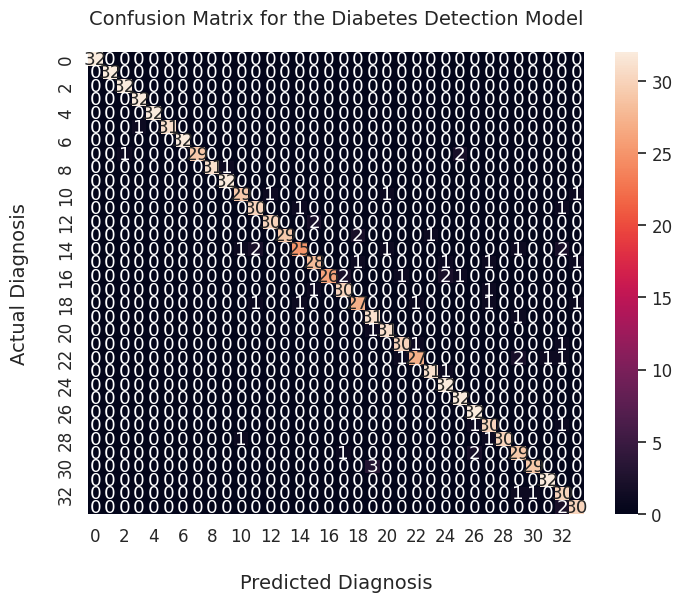

In [20]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [21]:
preds_val = model.predict(valid_generator)

33/33 [==============================] - 3s 79ms/step


In [22]:
evaluate_val = model.evaluate(valid_generator)

33/33 [==============================] - 2s 63ms/step - loss: 2.7765 - accuracy: 0.9628


In [23]:
evaluate_val

[2.77645206451416, 0.9627862572669983]

In [24]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([10,  0,  0, ..., 33, 33, 33])

In [25]:
y_real_val = valid_generator.classes
y_real_val

array([ 0,  0,  0, ..., 33, 33, 33], dtype=int32)

In [26]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.9685114503816794

In [27]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[29,  0,  0, ...,  0,  0,  0],
       [ 0, 30,  0, ...,  0,  0,  0],
       [ 0,  0, 29, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 31,  0,  0],
       [ 0,  0,  0, ...,  0, 31,  0],
       [ 0,  0,  0, ...,  0,  0, 31]])

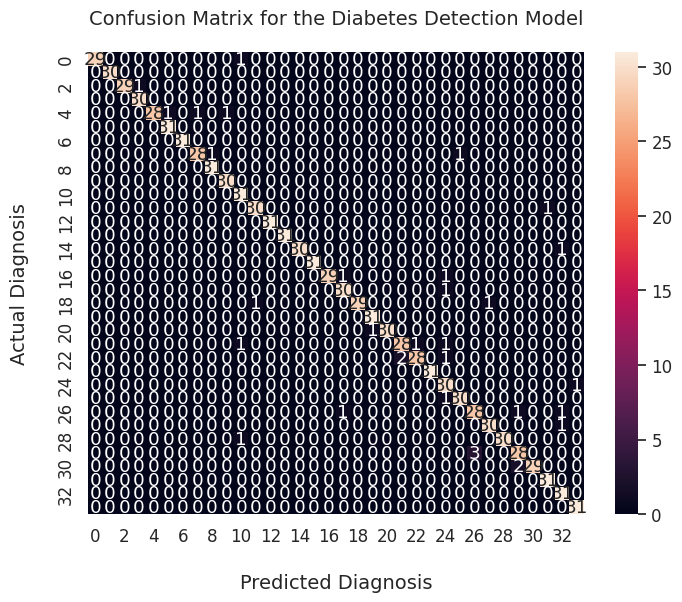

In [28]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()